In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
import scipy.cluster.hierarchy as sch
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
'''
#> library("MSA")
R> data("mcdonalds", package = "MSA")
R> names(mcdonalds)
'''
df = pd.read_csv("mcdonalds.csv")

In [3]:
'''
R> head(mcdonalds, 3)
''' 
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [4]:
'''
R> dim(mcdonalds)
'''
df.shape

(1453, 15)

In [5]:
'''
R> MD.x <- as.matrix(mcdonalds[, 1:11])
R> MD.x <- (MD.x == "Yes") + 0
R> round(colMeans(MD.x), 2)
'''
MD = df.iloc[:, 0:11].values
MD = (MD == "Yes").astype(int)
column_means = np.round(np.mean(MD, axis=0), 2)
column_means

array([0.55, 0.91, 0.09, 0.87, 0.53, 0.9 , 0.6 , 0.64, 0.36, 0.2 , 0.24])

In [6]:
'''
R> MD.pca <- prcomp(MD.x)
R> summary(MD.pca)
'''
pca = PCA()
MD_pca = pca.fit_transform(MD)
explained_variance_ratio = pca.explained_variance_ratio_
summary = {
    "Standard Deviation": np.sqrt(pca.explained_variance_),
    "Proportion of Variance": explained_variance_ratio,
    "Cumulative Proportion": np.cumsum(explained_variance_ratio)
}
summary

{'Standard Deviation': array([0.75704952, 0.60745556, 0.50461946, 0.39879859, 0.33740501,
        0.31027461, 0.28969732, 0.27512196, 0.2652511 , 0.24884182,
        0.23690284]),
 'Proportion of Variance': array([0.29944723, 0.19279721, 0.13304535, 0.08309578, 0.05948052,
        0.05029956, 0.0438491 , 0.03954779, 0.0367609 , 0.03235329,
        0.02932326]),
 'Cumulative Proportion': array([0.29944723, 0.49224445, 0.6252898 , 0.70838558, 0.7678661 ,
        0.81816566, 0.86201476, 0.90156255, 0.93832345, 0.97067674,
        1.        ])}

In [7]:
'''
R> print(MD.pca, digits = 1)
'''
np.set_printoptions(precision=1, suppress=True)
MD_pca

array([[ 0.4, -0.2,  0.7, ...,  0.2,  0.5, -0.6],
       [-0.2,  0.4, -0.7, ...,  0.1,  0.5, -0.5],
       [ 0.4,  0.7, -0.1, ..., -0.3,  0.1,  0.2],
       ...,
       [-0.2,  1.1,  0.2, ...,  0. ,  0.1, -0. ],
       [-1.2, -0. ,  0.6, ...,  0. , -0. , -0.1],
       [ 1.6,  0.3, -0. , ..., -0.1, -0.4, -0.5]])

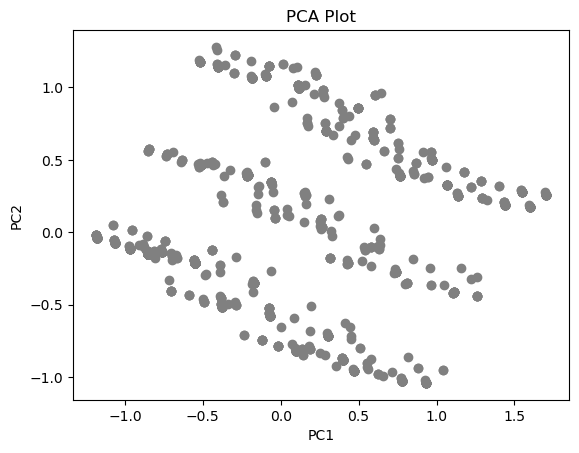

In [8]:
'''
R> library("flexclust")
R> plot(predict(MD.pca), col = "grey")
R> projAxes(MD.pca

'''

plt.scatter(MD_pca[:, 0], MD_pca[:, 1], c="grey")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Plot")
plt.show()
projected_data = np.dot(MD - np.mean(MD, axis=0), pca.components_[:2, :].T)

In [9]:
'''

R> set.seed(1234)
R> MD.km28 <- stepFlexclust(MD.x, 2:8, nrep = 10,
+ verbose = FALSE)
R> MD.km28 <- relabel(MD.km28)


'''

best_model = None
best_bic = float("inf")

for n_clusters in range(2, 9):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(MD)
    bic = kmeans.inertia_ + n_clusters * np.log(len(MD))
    if bic < best_bic:
        best_bic = bic
        best_model = kmeans

cluster_labels = best_model.labels_

unique_labels = np.unique(cluster_labels)
new_labels = list(range(len(unique_labels)))
cluster_mapping = dict(zip(unique_labels, new_labels))

cluster_labels_relabel = [cluster_mapping[label] for label in cluster_labels]

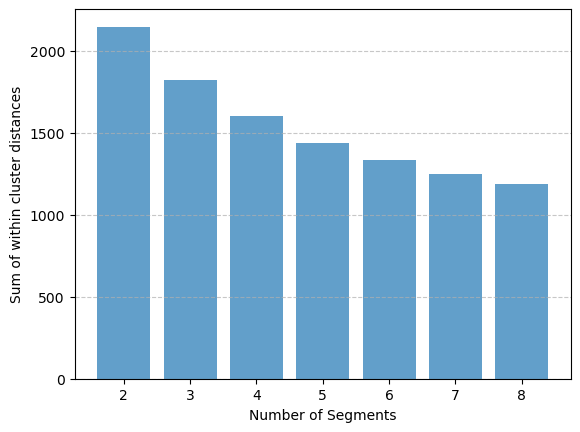

In [10]:
'''
R> plot(MD.km28, xlab = "number of segments")

'''

k_values = range(2, 9)
inertias = []

for n_clusters in k_values:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(MD)
    inertias.append(kmeans.inertia_)

plt.bar(k_values, inertias, align='center', alpha=0.7)
plt.xlabel("Number of Segments")
plt.ylabel("Sum of within cluster distances")
plt.xticks(k_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

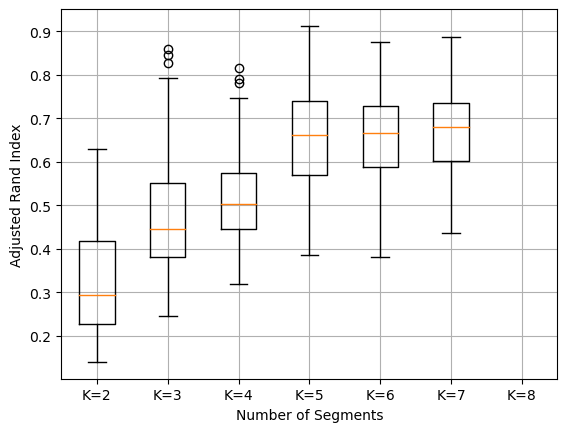

In [11]:
'''
R> set.seed(1234)
R> MD.b28 <- bootFlexclust(MD.x, 2:8, nrep = 10,
+ nboot = 100)

For Plotting:- 

R> plot(MD.b28, xlab = "number of segments",
+ ylab = "adjusted Rand index")
'''
n_bootstraps = 100
adjusted_rand_indices = []

for _ in range(n_bootstraps):
    sample_indices = np.random.choice(len(MD), size=len(MD), replace=True)
    bootstrapped_data = MD[sample_indices]
    
    cluster_labels = []
    
    for n_clusters in k_values:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
        kmeans.fit(bootstrapped_data)
        cluster_labels.append(kmeans.labels_)
  
    for i in range(len(k_values)):
        for j in range(i + 1, len(k_values)):
            adjusted_rand_index = adjusted_rand_score(cluster_labels[i], cluster_labels[j])
            adjusted_rand_indices.append((k_values[i], k_values[j], adjusted_rand_index))

k_value_pairs = [(pair[0], pair[1]) for pair in adjusted_rand_indices]
adjusted_rand_scores = [pair[2] for pair in adjusted_rand_indices]

adjusted_rand_values = [[] for _ in range(len(k_values))]
for i, k_pair in enumerate(k_value_pairs):
    idx = k_values.index(k_pair[0])
    adjusted_rand_values[idx].append(adjusted_rand_scores[i])
    
plt.boxplot(adjusted_rand_values, labels=[f"K={k}" for k in k_values])
plt.xlabel("Number of Segments")
plt.ylabel("Adjusted Rand Index")
plt.grid(True)
plt.show()

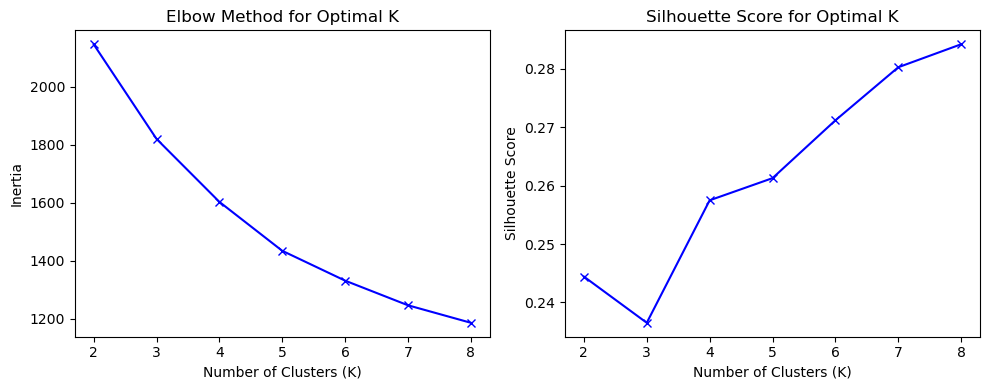

In [12]:
inertia_values = []
silhouette_scores = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(MD)
    

    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(MD, kmeans.labels_))
    
    
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_values, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')


plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')

plt.tight_layout()
plt.show()

In [13]:
'''
R> rev(table(mcdonalds$Like))
'''
frequency_table = df["Like"].value_counts()
reversed_table = frequency_table[::-1]

print(reversed_table)

-1               58
-2               59
-4               71
-3               73
I love it!+5    143
I hate it!-5    152
+1              152
+4              160
0               169
+2              187
+3              229
Name: Like, dtype: int64


In [14]:
'''
R> mcdonalds$Like.n <- 6 - as.numeric(mcdonalds$Like)
R> table(mcdonalds$Like.n)
'''

df["Like"] = pd.to_numeric(df["Like"], errors="coerce")

df["Like.n"] = 6 - df["Like"]

frequency_table = df["Like.n"].value_counts()

print(frequency_table)

3.0     229
4.0     187
6.0     169
2.0     160
5.0     152
9.0      73
10.0     71
8.0      59
7.0      58
Name: Like.n, dtype: int64


In [15]:
'''
R> f <- paste(names(mcdonalds)[1:11], collapse = "+")
R> f <- paste("Like.n ~ ", f, collapse = "")
R> f <- as.formula(f)
R> f

'''
column_names = df.columns[0:11]

formula_str = "Like.n ~ " + " + ".join(column_names)
print(formula_str)

Like.n ~ yummy + convenient + spicy + fattening + greasy + fast + cheap + tasty + expensive + healthy + disgusting


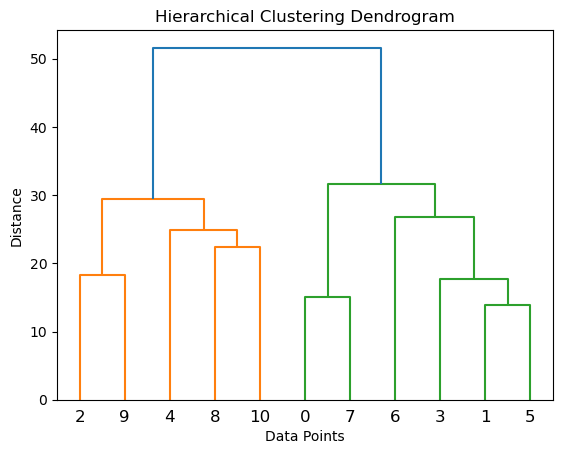

In [16]:
'''
R> MD.vclust <- hclust(dist(t(MD.x)))
'''
distance_matrix = sch.distance.pdist(MD.T)  # Transpose data for column-wise distance

linkage_matrix = sch.linkage(distance_matrix, method='ward')  # You can change the linkage method if needed

dendrogram = sch.dendrogram(linkage_matrix)

plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

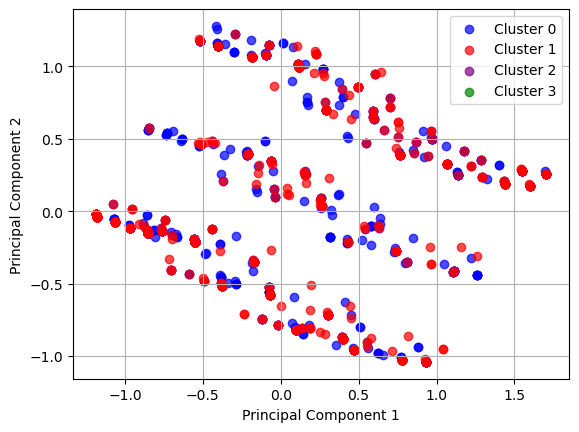

In [17]:
'''
R> plot(MD.k4, project = MD.pca, data = MD.x,
+ hull = FALSE, simlines = FALSE,
+ xlab = "principal component 1",
+ ylab = "principal component 2")
R> projAxes(MD.pca)

'''
pca = PCA(n_components=2)
pca_result = pca.fit_transform(MD)


MD_k4 = cluster_labels[0]

colors = ['blue', 'red', 'purple', 'green']

for cluster_id in range(4):
    cluster_data = pca_result[MD_k4 == cluster_id]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_id}', c=colors[cluster_id], alpha=0.7)


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.legend()
plt.grid(True)

plt.show()

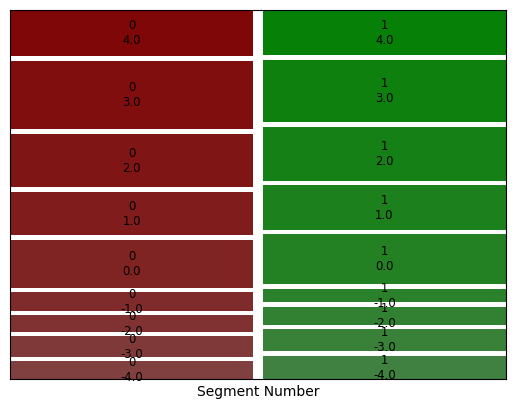

In [18]:
k4 = cluster_labels[0]
ctab = pd.crosstab(index=k4, columns=df['Like'], normalize='index')
mosaic(ctab.stack(), gap=0.02, title='', axes_label=False)

plt.xlabel('Segment Number')
plt.show()